## Setup

In [911]:
import seaborn as sns
import os
import pickle
import pandas as pd
from pandas import DataFrame
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes._subplots import Axes
import itertools
import matplotlib
from matplotlib.ticker import FormatStrFormatter



In [912]:
PROD_CAT = {
    "Mixed": {"renewable": False, "green": False},
    "Biomass": {"renewable": True, "green": True},
    "Fossil Brown coal/Lignite": {"renewable": False, "green": False},
    "Fossil Coal-derived gas": {"renewable": False, "green": False},
    "Fossil Gas": {"renewable": False, "green": False},
    "Fossil Hard coal": {"renewable": False, "green": False},
    "Fossil Oil": {"renewable": False, "green": False},
    "Fossil Oil shale": {"renewable": False, "green": False},
    "Fossil Peat": {"renewable": False, "green": False},
    "Geothermal": {"renewable": True, "green": True},
    "Hydro Pumped Storage": {"renewable": True, "green": True},
    "Hydro Run-of-river and poundage": {"renewable": True, "green": True},
    "Hydro Water Reservoir": {"renewable": True, "green": True},
    "Marine": {"renewable": True, "green": True},
    "Nuclear": {"renewable": False, "green": True},
    "Other renewable": {"renewable": True, "green": True},
    "Solar": {"renewable": True, "green": True},
    "Waste": {"renewable": False, "green": False},
    "Wind Offshore": {"renewable": True, "green": True},
    "Wind Onshore": {"renewable": True, "green": True},
    "Other": {"renewable": False, "green": False},
}

In [913]:
co2_best_df = pd.read_csv(os.path.join('Plots', 'data', 'LCA_CO2_BEST.csv'))
co2_worst_df = pd.read_csv(os.path.join('Plots', 'data', 'LCA_CO2_WORST.csv'))
co2_median_df = pd.read_csv(os.path.join('Plots', 'data', 'LCA_CO2_MEDIAN.csv'))


sns.set_context('paper', font_scale = 1.25)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.rcParams["font.family"] = 'CMU Serif'
plt.rcParams["hatch.linewidth"] = '0.75'
# plt.tight_layout()
hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])

results_pre_path = "Results"
save_pre_path = "Plots"

In [914]:
def load_df(name, subname=None):
    if subname is None:
        path = os.path.join(results_pre_path, name)
    else:
        path = os.path.join(results_pre_path, name, subname)
    pickle_path = os.path.join(path, "df.pkl")

    df =  pd.read_pickle(pickle_path)
    df = df.rename(columns=lambda x: x.replace("dc_cons_", ""), level=1) 
    return df

In [915]:
def load_result(name, subname=None):
    if subname is None:
        path = os.path.join(results_pre_path, name)
    else:
        path = os.path.join(results_pre_path, name, subname)
    json_path = os.path.join(path, "results.json")

    with open(json_path) as json_file:
        data = json.load(json_file)
        return data

In [916]:
def co2_by_type(df: DataFrame):
    df.drop(columns=[('Other','total_co2_best'), ('Other','total_co2_worst')])

    df.columns = pd.MultiIndex.from_arrays([df.columns.get_level_values(0), ['']*len(df.columns.get_level_values(0)), df.columns.get_level_values(1)])

    df[('CO2', 'total', 'Best')] = 0
    df[('CO2', 'total', 'Median')] = 0
    df[('CO2', 'total', 'Worst')] = 0

    for column in df['DC Consumption'][''].columns:
        best = (
            co2_best_df.loc[co2_best_df["TYPE"] == column, "CO2 [gCO2/kWh]"].values[0]
            * df[('DC Consumption','',column)]
        )
        median = (
            co2_median_df.loc[co2_median_df["TYPE"] == column, "CO2 [gCO2/kWh]"].values[0]
            * df[('DC Consumption','',column)]
        )
        worst = (
            co2_worst_df.loc[co2_worst_df["TYPE"] == column, "CO2 [gCO2/kWh]"].values[0]
            * df[('DC Consumption','',column)]
        )

        df['CO2', 'total', 'Best'] = df['CO2', 'total', 'Best'] + best

        df['CO2', 'total', 'Median'] = df['CO2', 'total', 'Median'] + median

        df['CO2', 'total', 'Worst'] = df['CO2', 'total', 'Worst'] + worst

        df[('CO2', column, 'Best')] = best
        df[('CO2', column, 'Median')] = median
        df[('CO2', column, 'Worst')] = worst



In [917]:
def summed(df: DataFrame):
    df2 = df[['DC Consumption', 'CO2']] / 1000
    data = df2.sum(axis=0).round(decimals=2)
    return data

In [918]:
def save_plot(graph: Axes, name, figname):
    write_path = os.path.join(save_pre_path, name)

    exists = os.path.exists(write_path)
    if not exists:
        os.makedirs(write_path)

    filename = os.path.join(write_path, figname)
    graph.get_figure().savefig(filename, bbox_inches='tight')

## Plotting Functions

#### Bar Plot Label https://www.statology.org/seaborn-barplot-show-values/

In [919]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                if not p.get_facecolor() == (0.34705882352941175, 0.4588235294117645, 0.6411764705882353, 1.0):
                    continue
                _x = p.get_x() + p.get_width() / 2 
                _y = p.get_height() + (p.get_height()*space)
                value = '{:.1f}'.format(p.get_height()) 
                ax.text(_x, _y, value, ha="center", rotation=45) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.4)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

#### Bars Width https://stackoverflow.com/a/44542112

In [920]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

#### Total Energy Use by Type

In [921]:
def plot_energy_use_by_type(df: DataFrame, name):
    plt.figure()


    df = df.to_frame('MWh')
    df = df.droplevel(level=0, axis=0)
    df = df.sort_values('MWh', ascending=False)
    df = df[df['MWh'] > 0.1]
    
    palette = {}
    for index, row in df.iterrows():
        if PROD_CAT[index]['renewable']:
            palette[index] = (0.8, 0.7254901960784313, 0.4549019607843137)
        else:
            palette[index] = (0.5058823529411764, 0.4470588235294118, 0.7019607843137254)

    graph = sns.barplot(y=df.index, x='MWh', data=df, palette=palette, linewidth=0.7, edgecolor=".2")
    sns.despine()
    show_values(graph, 'h', 0.35)

    for i, bar in enumerate(graph.patches):
        if PROD_CAT[df.index[i]]['renewable']:
            bar.set_hatch('/')
        else:
            bar.set_hatch('\\')

    legend = []

    for i, bar in enumerate(graph.patches):
        if PROD_CAT[df.index[i]]['renewable']:
            legend.append(bar)
            break

    for i, bar in enumerate(graph.patches):
        if not PROD_CAT[df.index[i]]['renewable']:
            legend.append(bar)
            break
    
    graph.legend(legend, ['Renewable', 'Non-Renewable'], title='Source Category', loc='lower right')
    graph.set(xlabel='DC Energy Consumption (MWh)', ylabel='Energy Source')
    save_plot(graph, name, 'energy_by_type.pdf')
    


#### Total CO2 Emissions by Type    

In [922]:
def plot_total_emissions_by_type(df: DataFrame, name):
    plt.figure(figsize=(9,4))
    


    df.index.names = ['Type', 'Case']
    df = df.unstack().reset_index()

    df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)
    df.sort_values('Median', inplace=True, ascending=False)
    df = df[df['Median'] > 1]

    df = pd.melt(df, id_vars=['Type'], value_vars=['Best', 'Median', 'Worst'])
    

    palette = [
        (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
        (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
        (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
    ]

    graph = sns.barplot(x='Type', y='value', hue='Case', data=df, palette=palette, linewidth=0.7, edgecolor=".2")
    sns.despine()
    graph.set_yscale('log')
    plt.xticks(rotation=45)
    graph.set(ylabel='kgCO2eq', xlabel='Energy Source')
    show_values(graph, 'v', .4)

    save_plot(graph, name, 'co2_by_type.pdf')

# Yearly Plot

In [1077]:
def year_trend(df, name):
    fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 8))
    # fig.tight_layout(pad=2.0)

    #CUE
    graph = sns.lineplot(data=df, x='index', y='CUE', marker='o', linewidth=2, markersize=7, ax=axes[0,0])
    axes[0,0].set_ylim([0, 1000])
    graph.set(ylabel='CUE', xlabel='Year')
    for x,y in zip(df['index'],df['CUE']):
        label = "{:.1f}".format(y)

        axes[0,0].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(3, -15), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765))

    #PUE
    graph = sns.lineplot(data=df, x='index', y='PUE', marker='o', linewidth=2, markersize=7, ax=axes[1,0])
    axes[1,0].set_ylim([0, 2])
    graph.set(ylabel='PUE', xlabel='Year')
    for x,y in zip(df['index'],df['PUE']):
        label = "{:.2f}".format(y)

        axes[1,0].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -15), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765))
    axes[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #APCr 
    graph = sns.lineplot(data=df, x='index', y='APCr', marker='o', linewidth=2, markersize=7, ax=axes[2,0])
    axes[2,0].set_ylim([0, 0.6])
    graph.set(ylabel='APCr', xlabel='Year')
    for x,y in zip(df['index'],df['APCr']):
        label = "{:.2f}".format(y)

        axes[2,0].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -15), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[2,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #GEC ren
    graph = sns.lineplot(data=df, x='index', y='GEC (ren)', marker='o', linewidth=2, markersize=7, ax=axes[0,1])
    axes[0,1].set_ylim([0, 0.2])
    graph.set(ylabel='GEC (ren)', xlabel='Year')
    for x,y in zip(df['index'],df['GEC (ren)']):
        label = "{:.2f}".format(y)

        axes[0,1].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -18), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #GEC (green)
    graph = sns.lineplot(data=df, x='index', y='GEC (green)', marker='o', linewidth=2, markersize=7, ax=axes[1,1])
    axes[1,1].set_ylim([0, 0.25])
    graph.set(ylabel='GEC (green)', xlabel='Year')
    for x,y in zip(df['index'],df['GEC (green)']):
        label = "{:.2f}".format(y)

        axes[1,1].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -18), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #CO2 (kg)
    graph = sns.lineplot(data=df, x='index', y='CO2 (tonnes)', marker='o', linewidth=2, markersize=7, ax=axes[2,1])
    axes[2,1].set_ylim([0,60])
    graph.set(ylabel='CO2 (tonnes)', xlabel='Year')
    for x,y in zip(df['index'],df['CO2 (tonnes)']):
        label = "{:.2f}".format(y)

        axes[2,1].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -15), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[2,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.setp(axes, xticks=[2016, 2017, 2018, 2019, 2020])

    save_plot(fig, name, 'year_trend.pdf')



In [1083]:
def year_trend(df, name):
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(11, 5))
    # fig.tight_layout(pad=2.0)

    #APCr 
    graph = sns.lineplot(data=df, x='index', y='APCr', marker='o', linewidth=2, markersize=7, ax=axes[0,0])
    axes[0,0].set_ylim([0, 0.7])
    graph.set(ylabel='APCr', xlabel='Month')
    for x,y in zip(df['index'],df['APCr']):
        label = "{:.2f}".format(y)

        axes[0,0].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -15), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #CO2 (kg)
    graph = sns.lineplot(data=df, x='index', y='CO2 (tonnes)', marker='o', linewidth=2, markersize=7, ax=axes[0,1])
    axes[0,1].set_ylim([0,50])
    graph.set(ylabel='CO2 (tonnes)', xlabel='Month')
    for x,y in zip(df['index'],df['CO2 (tonnes)']):
        label = "{:.2f}".format(y)

        axes[0,1].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -15), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #GEC ren
    graph = sns.lineplot(data=df, x='index', y='GEC (ren)', marker='o', linewidth=2, markersize=7, ax=axes[1,0])
    axes[1,0].set_ylim([0, 0.25])
    graph.set(ylabel='GEC (ren)', xlabel='Month')
    for x,y in zip(df['index'],df['GEC (ren)']):
        label = "{:.2f}".format(y)

        axes[1,0].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -18), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #GEC (green)
    graph = sns.lineplot(data=df, x='index', y='GEC (green)', marker='o', linewidth=2, markersize=7, ax=axes[1,1])
    axes[1,1].set_ylim([0, 0.25])
    graph.set(ylabel='GEC (green)', xlabel='Month')
    for x,y in zip(df['index'],df['GEC (green)']):
        label = "{:.2f}".format(y)

        axes[1,1].annotate(label, 
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0, -18), 
                    ha='center',
                    color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) 
    axes[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.setp(axes, xticks=[1, 4, 7, 10], xticklabels=['Jan','April', 'July', 'Oct'])

    # axes[1,1].sharey(axes[1,0])

    save_plot(fig, name, 'year_trend.pdf')



# Main

## Baseline

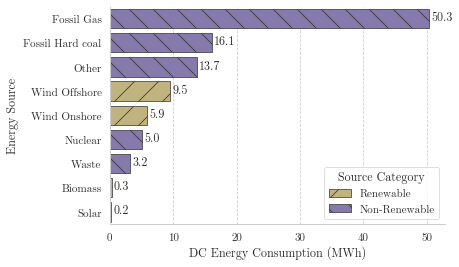

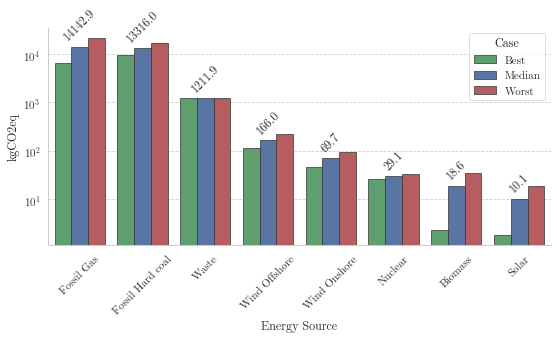

In [924]:
name = 'baseline'
subname = ''
df = load_df(name)

co2_by_type(df)
df_summmed = summed(df)
plot_energy_use_by_type(df_summmed['DC Consumption'], name)
plot_total_emissions_by_type(df_summmed['CO2'], name)

## Optimistic

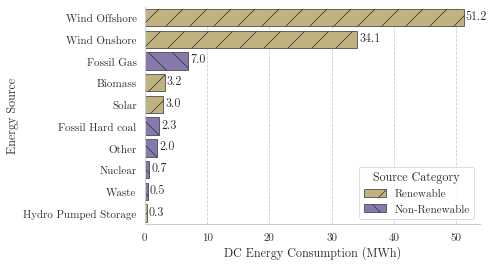

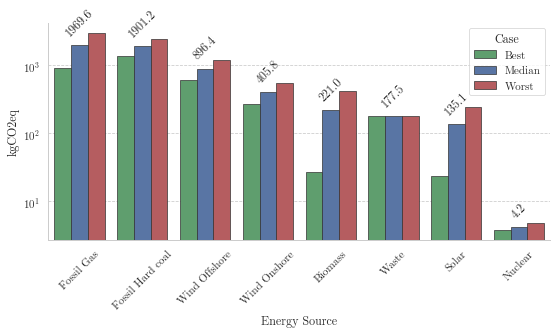

In [925]:
name = 'optimistic'
subname = ''
df = load_df(name)

co2_by_type(df)
df_summmed = summed(df)
plot_energy_use_by_type(df_summmed['DC Consumption'], name)
plot_total_emissions_by_type(df_summmed['CO2'], name)


## Yearly


   index      CO2 (kg)  GEC (ren)  GEC (green)      APCr         CUE   PUE  \
0   2016  55925.899194   0.059364     0.114612  0.417671  852.305810  1.60   
1   2017  47350.571840   0.083749     0.139655  0.450522  721.574455  1.59   
2   2018  49907.430985   0.077742     0.122229  0.531300  760.300032  1.58   
3   2019  41198.881828   0.067593     0.109314  0.453219  627.308033  1.67   
4   2020  40400.539919   0.151995     0.200410  0.480432  615.857681  1.59   

   CO2 (tonnes)  
0     55.925899  
1     47.350572  
2     49.907431  
3     41.198882  
4     40.400540  


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

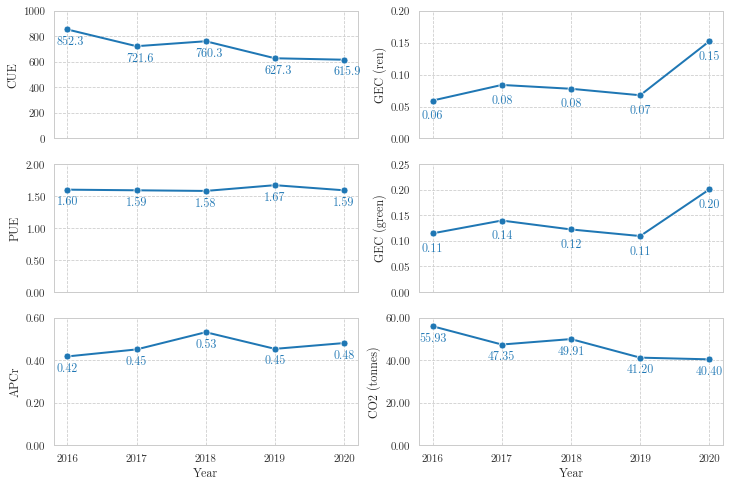

In [1041]:
name = 'yearly'

results = {}

years = [2016, 2017, 2018, 2019, 2020]
pue = {
    2016 : 1.6,
    2017 : 1.59,
    2018: 1.58,
    2019: 1.67,
    2020: 1.59
}

for year in years:
    results[year] = load_result(name, str(year))['builtin_metrics']
    results[year]['PUE'] = pue[year]

df = DataFrame.from_dict(results, orient='index')
df.reset_index(inplace=True)
df['CO2 (tonnes)'] = df['CO2 (kg)'] / 1000
print(df)

year_trend(df, name)

## Seasonal

   index      CO2 (kg)  GEC (ren)  GEC (green)      APCr         CUE  \
0      1  36676.937941   0.123592     0.168780  0.589530  559.227335   
1      4  34712.829304   0.084557     0.125390  0.395918  528.993765   
2      7  38926.616307   0.078197     0.120194  0.371396  593.204375   
3     10  40633.690789   0.162620     0.209725  0.480870  618.968400   

   CO2 (tonnes)  
0     36.676938  
1     34.712829  
2     38.926616  
3     40.633691  


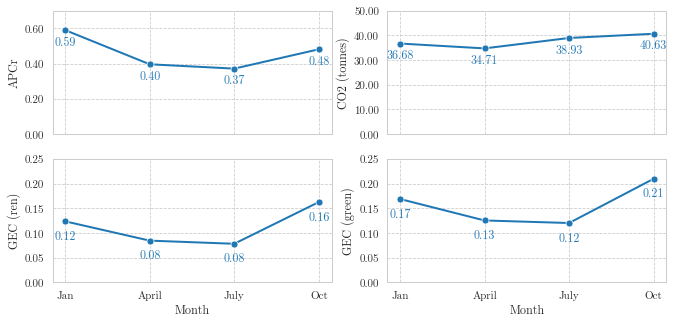

In [1084]:
name = 'season'

results = {}

years = [1, 4, 7, 10]

for year in years:
    results[year] = load_result(name, str(year))['builtin_metrics']

df = DataFrame.from_dict(results, orient='index')
df.reset_index(inplace=True)
df['CO2 (tonnes)'] = df['CO2 (kg)'] / 1000
print(df)

year_trend(df, name)
